In [1]:
import os
import random

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Fix random seeds so every model trains with identical initial conditions
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.keras.utils.set_random_seed(SEED)
try:
    tf.config.experimental.enable_op_determinism()
except Exception:
    pass

c:\Users\User\Desktop\crowd_based_signals_for_crypto_trading\.venv\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\User\Desktop\crowd_based_signals_for_crypto_trading\.venv\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\User\Desktop\crowd_based_signals_for_crypto_trading\.venv\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime versi

In [2]:
data = pd.read_csv("eth_reddit_sentiments_FINAL.csv")

# Processing missing Sentiment Data

In [3]:
def get_hours(x):
    x = str(x)
    if len(x) == 3:
        return int(x[0])
    if len(x) == 2:
        return 0
    return int(x[0] + x[1])

data['time'] = data['time'].apply(lambda x: get_hours(x))

In [4]:
# Identify missing hourly entries per date
all_hours = set(range(24))

def find_missing_hours(hour_series: pd.Series) -> list:
    hours = pd.to_numeric(hour_series, errors="coerce").dropna().astype(int)
    return sorted(all_hours - set(hours))

missing_hours = (
    data.groupby("date")["time"].apply(find_missing_hours).reset_index(name="missing_hours")
)

missing_hours

,date,missing_hours
0,2025-10-26,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,2025-10-27,"[8, 10]"
2,2025-10-28,"[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, ..."
3,2025-10-29,"[8, 10]"
4,2025-10-30,"[8, 10]"
5,2025-10-31,"[8, 10]"
6,2025-11-01,"[8, 10]"
7,2025-11-02,"[8, 10]"
8,2025-11-03,"[8, 10]"
9,2025-11-04,"[8, 10]"


In [5]:
data = data[data['date'] != '2025-10-26']
data = data[data['date'] != '2025-10-27']
data = data[data['date'] != '2025-10-28']
data = data[data['date'] != '2025-11-23']
data = data[data['date'] != '2025-12-07']

In [6]:
missing_hours = (
    data.groupby("date")["time"].apply(find_missing_hours).reset_index(name="missing_hours")
)

missing_hours

,date,missing_hours
0,2025-10-29,"[8, 10]"
1,2025-10-30,"[8, 10]"
2,2025-10-31,"[8, 10]"
3,2025-11-01,"[8, 10]"
4,2025-11-02,"[8, 10]"
5,2025-11-03,"[8, 10]"
6,2025-11-04,"[8, 10]"
7,2025-11-05,"[8, 10]"
8,2025-11-06,"[8, 10]"
9,2025-11-07,"[8, 10]"


In [7]:
# Expand each date to include all 24 hourly slots, filling from the prior timestep
sentiment_cols = [col for col in data.columns if col not in {"date", "time", "file"}]

data["hour"] = pd.to_numeric(data["time"], errors="coerce").astype("Int64")

def expand_daily_hours(group: pd.DataFrame) -> pd.DataFrame:
    date_value = group["date"].iloc[0]
    expanded = group.sort_values("hour").set_index("hour").reindex(range(24))
    expanded["date"] = expanded["date"].ffill().fillna(date_value)
    expanded["file"] = expanded["file"].ffill()
    expanded[sentiment_cols] = expanded[sentiment_cols].ffill()
    expanded["time"] = expanded.index.astype(int).astype(str).str.zfill(2)
    return expanded.reset_index(drop=True)

In [8]:
data

,date,time,file,b_b1,b_b1_prefix,b_b2,b_b2_prefix,b_a4,b_a4_prefix,hour
41,2025-10-29,0,reddit_data_eth_2025-10-29_0029.csv,0.084257,0.131754,0.073613,0.103926,0.075610,0.114634,0
42,2025-10-29,1,reddit_data_eth_2025-10-29_0120.csv,0.083848,0.131130,0.072913,0.103488,0.075243,0.114078,1
43,2025-10-29,2,reddit_data_eth_2025-10-29_0232.csv,0.086245,0.131282,0.077862,0.108658,0.077859,0.114355,2
44,2025-10-29,3,reddit_data_eth_2025-10-29_0317.csv,0.086245,0.131282,0.078034,0.107320,0.077859,0.114355,3
45,2025-10-29,4,reddit_data_eth_2025-10-29_0424.csv,0.086245,0.131282,0.078777,0.107892,0.077859,0.114355,4
...,...,...,...,...,...,...,...,...,...,...
585,2025-11-22,19,reddit_data_eth_2025-11-22_1916.csv,0.094095,0.124373,0.074333,0.104947,0.083512,0.107066,19
586,2025-11-22,20,reddit_data_eth_2025-11-22_2037.csv,0.095108,0.125973,0.074324,0.106622,0.083156,0.108742,20
587,2025-11-22,21,reddit_data_eth_2025-11-22_2124.csv,0.095108,0.125973,0.074370,0.106457,0.083156,0.108742,21
588,2025-11-22,22,reddit_data_eth_2025-11-22_2218.csv,0.094705,0.125517,0.075552,0.109248,0.082803,0.108280,22


In [9]:
data = data.groupby("date", group_keys=False).apply(expand_daily_hours).reset_index(drop=True)
data

C:\Users\User\AppData\Local\Temp\ipykernel_11812\4120056486.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby("date", group_keys=False).apply(expand_daily_hours).reset_index(drop=True)


,date,time,file,b_b1,b_b1_prefix,b_b2,b_b2_prefix,b_a4,b_a4_prefix
0,2025-10-29,00,reddit_data_eth_2025-10-29_0029.csv,0.084257,0.131754,0.073613,0.103926,0.075610,0.114634
1,2025-10-29,01,reddit_data_eth_2025-10-29_0120.csv,0.083848,0.131130,0.072913,0.103488,0.075243,0.114078
2,2025-10-29,02,reddit_data_eth_2025-10-29_0232.csv,0.086245,0.131282,0.077862,0.108658,0.077859,0.114355
3,2025-10-29,03,reddit_data_eth_2025-10-29_0317.csv,0.086245,0.131282,0.078034,0.107320,0.077859,0.114355
4,2025-10-29,04,reddit_data_eth_2025-10-29_0424.csv,0.086245,0.131282,0.078777,0.107892,0.077859,0.114355
...,...,...,...,...,...,...,...,...,...
595,2025-11-22,19,reddit_data_eth_2025-11-22_1916.csv,0.094095,0.124373,0.074333,0.104947,0.083512,0.107066
596,2025-11-22,20,reddit_data_eth_2025-11-22_2037.csv,0.095108,0.125973,0.074324,0.106622,0.083156,0.108742
597,2025-11-22,21,reddit_data_eth_2025-11-22_2124.csv,0.095108,0.125973,0.074370,0.106457,0.083156,0.108742
598,2025-11-22,22,reddit_data_eth_2025-11-22_2218.csv,0.094705,0.125517,0.075552,0.109248,0.082803,0.108280


# Building model with sentiment features

In [10]:
# Build a continuous hourly index for the sentiment snapshots
sentiment_hourly = data.copy()
sentiment_hourly["hour"] = (
    pd.to_numeric(sentiment_hourly["time"], errors="coerce")
    .fillna(method="ffill")
    .fillna(method="bfill")
    .astype(int)
)
sentiment_hourly["timestamp"] = pd.to_datetime(sentiment_hourly["date"]) + pd.to_timedelta(sentiment_hourly["hour"], unit="h")
sentiment_hourly = sentiment_hourly.sort_values("timestamp").set_index("timestamp")
sentiment_hourly[sentiment_cols] = sentiment_hourly[sentiment_cols].apply(pd.to_numeric, errors="coerce")
sentiment_hourly[sentiment_cols] = sentiment_hourly[sentiment_cols].interpolate(method="time").ffill().bfill()
lag_prefixes = ("b_b1", "b_b1_prefix", "b_b2", "b_b2_prefix", "b_a4", "b_a4_prefix")
lag_columns = [col for col in sentiment_cols if any(col.lower().startswith(prefix) for prefix in lag_prefixes)]
if lag_columns:
    # Lag select sentiment aggregations by one hour to avoid lookahead bias
    sentiment_hourly[lag_columns] = sentiment_hourly[lag_columns].shift(1)
sentiment_hourly = sentiment_hourly[sentiment_cols]
sentiment_hourly.head()

C:\Users\User\AppData\Local\Temp\ipykernel_11812\4110069953.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method="ffill")
C:\Users\User\AppData\Local\Temp\ipykernel_11812\4110069953.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method="bfill")


,b_b1,b_b1_prefix,b_b2,b_b2_prefix,b_a4,b_a4_prefix
timestamp,,,,,,
2025-10-29 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2025-10-29 01:00:00,0.084257,0.131754,0.073613,0.103926,0.075610,0.114634
2025-10-29 02:00:00,0.083848,0.131130,0.072913,0.103488,0.075243,0.114078
2025-10-29 03:00:00,0.086245,0.131282,0.077862,0.108658,0.077859,0.114355
2025-10-29 04:00:00,0.086245,0.131282,0.078034,0.107320,0.077859,0.114355


In [11]:
# Load hourly ETH price candles and align to sentiment window
price_cols = ["Close", "High", "Low", "Open", "Volume"]
eth_hourly = (
    pd.read_csv("eth_prices.csv", parse_dates=["Datetime"])
    .sort_values("Datetime")
    .set_index("Datetime")
 )
sentiment_window = slice(sentiment_hourly.index.min(), sentiment_hourly.index.max())
eth_hourly = eth_hourly.loc[sentiment_window]
eth_hourly.head()

,Close,High,Low,Open,Volume
Datetime,,,,,
2025-10-29 00:00:00,3977.175537,3990.419922,3973.827637,3979.216797,739233792
2025-10-29 01:00:00,3987.258545,4005.795166,3966.927979,3975.341064,0
2025-10-29 02:00:00,4004.266113,4004.677246,3983.914307,3985.222168,0
2025-10-29 03:00:00,3998.709717,4004.286621,3990.453857,4004.286621,0
2025-10-29 04:00:00,4015.853516,4019.171875,3998.728760,3998.728760,802967552


In [12]:
# Price-derived features plus sentiment columns
price_features = eth_hourly.copy()
price_features["Log_Close"] = np.log(price_features["Close"]).diff()
price_features["Log_High"] = np.log(price_features["High"]).diff()
price_features["Log_Low"] = np.log(price_features["Low"]).diff()
price_features["Log_Open"] = np.log(price_features["Open"]).diff()
price_features["Log_Volume"] = np.log(price_features["Volume"].replace(0, np.nan)).diff()
derived_cols = [
    "Log_Close","Log_High","Log_Low","Log_Open","Log_Volume"
]
price_features = price_features[derived_cols].dropna()
model_base = price_features.join(sentiment_hourly, how="inner").dropna()
model_base.head()

,Log_Close,Log_High,Log_Low,Log_Open,Log_Volume,b_b1,b_b1_prefix,b_b2,b_b2_prefix,b_a4,b_a4_prefix
2025-10-29 17:00:00,0.010577,0.008307,0.007630,0.002888,-0.297552,0.090449,0.135165,0.081181,0.111002,0.082126,0.118357
2025-10-29 18:00:00,-0.018189,0.001726,-0.028586,0.012525,1.886781,0.090449,0.135165,0.080331,0.110080,0.082126,0.118357
2025-10-29 19:00:00,-0.003192,-0.014496,0.011060,-0.023815,-3.848515,0.090231,0.134840,0.080862,0.109839,0.081928,0.118072
2025-10-30 01:00:00,0.002009,0.002949,0.005677,0.004776,2.023984,0.085856,0.132909,0.073512,0.104161,0.077295,0.115942
2025-10-30 04:00:00,-0.011922,-0.003393,-0.020386,-0.003183,0.663911,0.085856,0.132909,0.072889,0.103794,0.077295,0.115942


In [13]:
# Hull MA-driven multi-class labels (mirrors Preprocessing_labelling.ipynb)
def hull_moving_average(series: pd.Series, window: int) -> pd.Series:
    if not isinstance(series, pd.Series):
        raise TypeError("Input must be a pandas Series.")
    half_window = max(1, window // 2)
    wma_half = series.ewm(span=half_window, adjust=False).mean()
    wma_full = series.ewm(span=window, adjust=False).mean()
    raw_hma = (2 * wma_half) - wma_full
    sqrt_window = max(1, int(np.sqrt(window)))
    return raw_hma.ewm(span=sqrt_window, adjust=False).mean()

def calculate_atr(df: pd.DataFrame, window: int = 14) -> pd.DataFrame:
    df = df.copy()
    df['high_low'] = df['High'] - df['Low']
    df['high_close_prev'] = np.abs(df['High'] - df['Close'].shift())
    df['low_close_prev'] = np.abs(df['Low'] - df['Close'].shift())
    df['true_range'] = df[['high_low', 'high_close_prev', 'low_close_prev']].max(axis=1)
    df['atr'] = df['true_range'].ewm(span=window, adjust=False).mean()
    df = df.drop(columns=['high_low', 'high_close_prev', 'low_close_prev', 'true_range'])
    return df

eth_hourly = calculate_atr(eth_hourly, window=14)
eth_hourly['hull_sma'] = hull_moving_average(eth_hourly['Close'], window=50)
eth_hourly['hull_sma_gradient'] = eth_hourly['hull_sma'].diff()
eth_hourly['prev_gradient'] = eth_hourly['hull_sma_gradient'].shift(1)

epsilon = 1e-6
atr_multiplier = 2.25
lookahead_periods = 15  # hours ahead to confirm reversal
eth_hourly['future_price'] = eth_hourly['Close'].shift(-lookahead_periods)
eth_hourly['raw_label'] = 0
eth_hourly.loc[
    (eth_hourly['prev_gradient'] < -epsilon)
    & (eth_hourly['future_price'] > eth_hourly['Close'] + (atr_multiplier * eth_hourly['atr'])),
    'raw_label',
] = 1
eth_hourly.loc[
    (eth_hourly['prev_gradient'] > epsilon)
    & (eth_hourly['future_price'] < eth_hourly['Close'] - (atr_multiplier * eth_hourly['atr'])),
    'raw_label',
] = 2
eth_hourly = eth_hourly.drop(columns=['future_price'])

trend_values = np.empty(len(eth_hourly), dtype=float)
trend_values[:] = np.nan
current_trend = 3
for idx, raw_value in enumerate(eth_hourly['raw_label'].values):
    if raw_value == 1:
        current_trend = 3
    elif raw_value == 2:
        current_trend = 4
    trend_values[idx] = current_trend
eth_hourly['trend_label'] = trend_values
eth_hourly['Train_label'] = eth_hourly['raw_label']
zero_mask = eth_hourly['Train_label'] == 0
eth_hourly.loc[zero_mask, 'Train_label'] = eth_hourly.loc[zero_mask, 'trend_label']

label_series = (eth_hourly['Train_label'].dropna().astype(int) - 1).astype(int)
common_index = model_base.index.intersection(label_series.index)
feature_frame = model_base.loc[common_index]
labels_aligned = label_series.loc[common_index]
feature_frame.head()

,Log_Close,Log_High,Log_Low,Log_Open,Log_Volume,b_b1,b_b1_prefix,b_b2,b_b2_prefix,b_a4,b_a4_prefix
2025-10-29 17:00:00,0.010577,0.008307,0.007630,0.002888,-0.297552,0.090449,0.135165,0.081181,0.111002,0.082126,0.118357
2025-10-29 18:00:00,-0.018189,0.001726,-0.028586,0.012525,1.886781,0.090449,0.135165,0.080331,0.110080,0.082126,0.118357
2025-10-29 19:00:00,-0.003192,-0.014496,0.011060,-0.023815,-3.848515,0.090231,0.134840,0.080862,0.109839,0.081928,0.118072
2025-10-30 01:00:00,0.002009,0.002949,0.005677,0.004776,2.023984,0.085856,0.132909,0.073512,0.104161,0.077295,0.115942
2025-10-30 04:00:00,-0.011922,-0.003393,-0.020386,-0.003183,0.663911,0.085856,0.132909,0.072889,0.103794,0.077295,0.115942


In [14]:
# Scale features and build lookback sequences
feature_columns = feature_frame.columns.tolist()
scaler = MinMaxScaler()
feature_scaled = pd.DataFrame(
    scaler.fit_transform(feature_frame),
    index=feature_frame.index,
    columns=feature_columns,
 )
lookback = 24
num_classes = 4
def create_sequences(features: pd.DataFrame, labels: pd.Series, window: int):
    sequences, label_list, time_index = [], [], []
    feature_values = features.values.astype(np.float32)
    label_values = labels.values.astype(int)
    for start_idx in range(len(features) - window):
        end_idx = start_idx + window
        sequences.append(feature_values[start_idx:end_idx])
        label_list.append(label_values[end_idx])
        time_index.append(features.index[end_idx])
    return np.asarray(sequences, dtype=np.float32), np.asarray(label_list, dtype=np.int64), pd.Index(time_index)
X_seq, y_seq, seq_timestamps = create_sequences(feature_scaled, labels_aligned, lookback)
y_seq_ohe = to_categorical(y_seq, num_classes=num_classes)
X_seq.shape, y_seq_ohe.shape

((146, 24, 11), (146, 4))

In [15]:
# Deterministic chronological train/validation split
split_idx = int(0.8 * len(X_seq))
X_train, X_val = X_seq[:split_idx], X_seq[split_idx:]
Y_train, Y_val = y_seq_ohe[:split_idx], y_seq_ohe[split_idx:]
train_ts, val_ts = seq_timestamps[:split_idx], seq_timestamps[split_idx:]
X_train.shape, X_val.shape

((116, 24, 11), (30, 24, 11))

# Model using B-B1 (no prefix) Aggregation

In [16]:
# Copies of train/validation tensors restricted to log price + B-B1 sentiment columns
bb1_cols = ["b_b1"]
if not bb1_cols:
    raise ValueError("No B-B1 columns found among sentiment features.")
bb1_feature_cols = derived_cols + bb1_cols
bb1_indices = [feature_columns.index(col) for col in bb1_feature_cols]
X_train_bb1 = X_train[..., bb1_indices].copy()
X_val_bb1 = X_val[..., bb1_indices].copy()
X_train_bb1.shape, X_val_bb1.shape

((116, 24, 6), (30, 24, 6))

In [17]:
# Sentiment-aware CNN-GRU architecture (log price + B-B1 features)
tf.keras.backend.clear_session()
model = models.Sequential([
    layers.Conv1D(64, kernel_size=3, activation="relu", padding="causal", input_shape=X_train_bb1.shape[1:]),
    layers.Conv1D(64, kernel_size=3, activation="relu", padding="causal"),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(64, kernel_size=3, activation="relu", padding="causal"),
    layers.Dropout(0.2),
    layers.GRU(64, return_sequences=False),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation="softmax"),
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

epochs = 40
batch_size = 32
history = model.fit(
    X_train_bb1,
    Y_train,
    validation_data=(X_val_bb1, Y_val),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
 )

c:\Users\User\Desktop\crowd_based_signals_for_crypto_trading\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 24, 64)         │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 24, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 12, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,300 (216.02 KB)

 Trainable params: 55,300 (216.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 269ms/step - accuracy: 0.5690 - loss: 1.3320 - val_accuracy: 0.4333 - val_loss: 1.2904
Epoch 2/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.5862 - loss: 1.1948 - val_accuracy: 0.4333 - val_loss: 1.3075
Epoch 3/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.5862 - loss: 1.1450 - val_accuracy: 0.4333 - val_loss: 1.4169
Epoch 4/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5862 - loss: 1.1999 - val_accuracy: 0.4333 - val_loss: 1.3376
Epoch 5/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5862 - loss: 1.1120 - val_accuracy: 0.4333 - val_loss: 1.3170
Epoch 6/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.5862 - loss: 1.1266 - val_accuracy: 0.4333 - val_loss: 1.3373
Epoch 7/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5862 - loss: 1.1161 - val_accuracy: 0.4333 - val_loss: 1.3532
Epoch 8/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5862 - loss: 1.1172 - val_accuracy: 0.4333 - val_loss: 1.3405

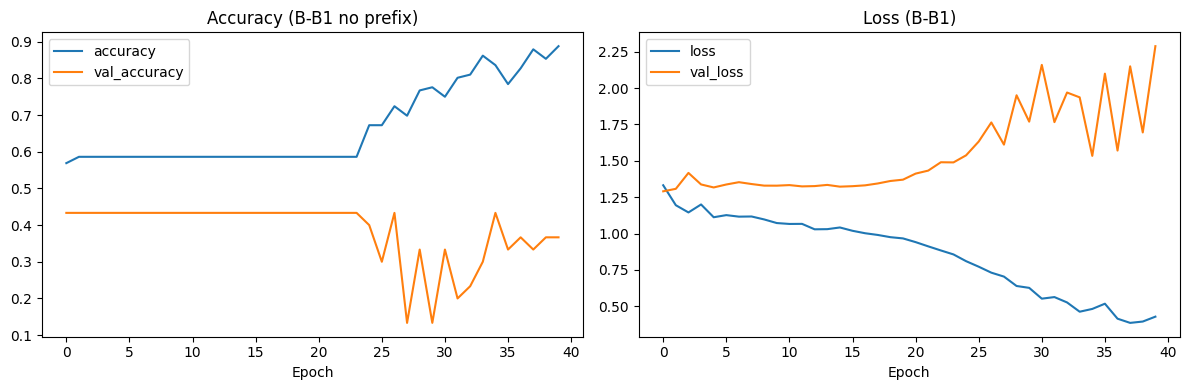

In [18]:
# Learning curves (B-B1)
history_df = pd.DataFrame(history.history)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
history_df[["accuracy", "val_accuracy"]].plot(ax=axes[0])
axes[0].set_title("Accuracy (B-B1 no prefix)")
axes[0].set_xlabel("Epoch")
history_df[["loss", "val_loss"]].plot(ax=axes[1])
axes[1].set_title("Loss (B-B1)")
axes[1].set_xlabel("Epoch")
plt.tight_layout()

In [19]:
# Validation predictions and metrics
val_prob = model.predict(X_val_bb1)
val_pred = np.argmax(val_prob, axis=1)
val_true = np.argmax(Y_val, axis=1)
print("B-B1 Aggregation no prefix")
print(classification_report(val_true, val_pred, digits=3))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
B-B1 Aggregation no prefix
              precision    recall  f1-score   support

           0      0.000     0.000     0.000         6
           1      0.167     0.500     0.250         2
           2      0.000     0.000     0.000         9
           3      0.476     0.769     0.588        13

    accuracy                          0.367        30
   macro avg      0.161     0.317     0.210        30
weighted avg      0.217     0.367     0.272        30



c:\Users\User\Desktop\crowd_based_signals_for_crypto_trading\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\User\Desktop\crowd_based_signals_for_crypto_trading\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\User\Desktop\crowd_based_signals_for_crypto_trading\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to co

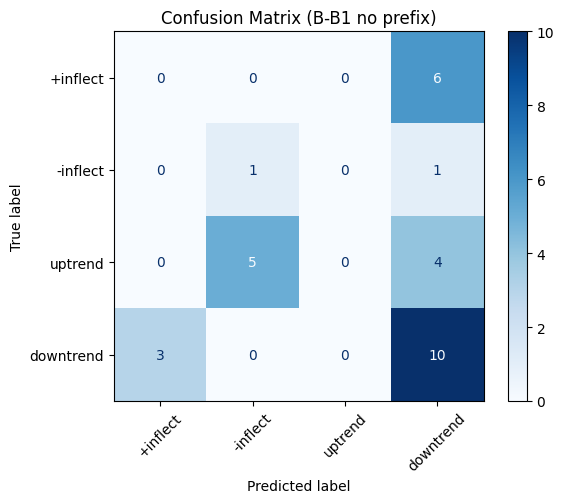

In [20]:
# Confusion matrix (B-B1 no prefix)
cm = confusion_matrix(val_true, val_pred, labels=[0, 1, 2, 3])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["+inflect","-inflect","uptrend","downtrend"])
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix (B-B1 no prefix)")
plt.show()

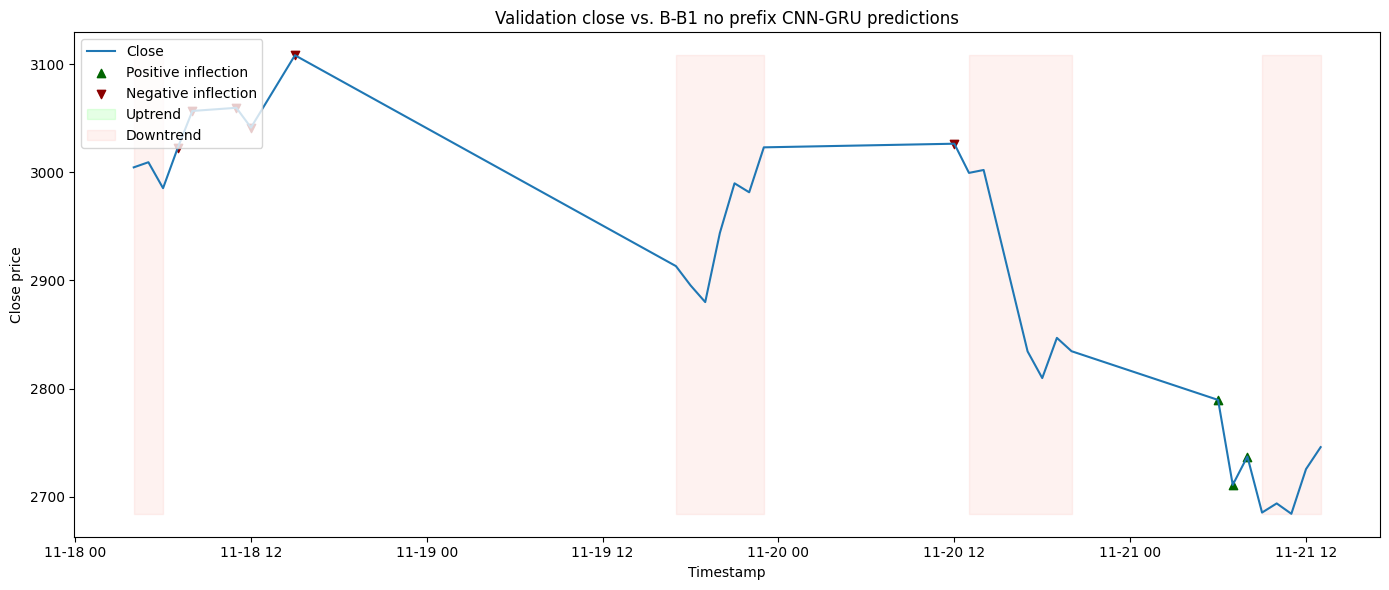

In [21]:
# Overlay predictions on price path (B-B1 no prefix)
val_price_series = eth_hourly.loc[val_ts, "Close"]
pred_df = pd.DataFrame({
    "timestamp": val_ts,
    "close": val_price_series.values,
    "pred_label": val_pred,
}).set_index("timestamp")
plt.figure(figsize=(14, 6))
plt.plot(pred_df.index, pred_df["close"], label="Close")
mask_up = pred_df["pred_label"] == 2
mask_down = pred_df["pred_label"] == 3
mask_up_inflect = pred_df["pred_label"] == 0
mask_down_inflect = pred_df["pred_label"] == 1
plt.scatter(pred_df.index[mask_up_inflect], pred_df["close"][mask_up_inflect], marker="^", color="darkgreen", label="Positive inflection")
plt.scatter(pred_df.index[mask_down_inflect], pred_df["close"][mask_down_inflect], marker="v", color="darkred", label="Negative inflection")
plt.fill_between(pred_df.index, pred_df["close"].min(), pred_df["close"].max(), where=mask_up, alpha=0.1, color="lime", label="Uptrend")
plt.fill_between(pred_df.index, pred_df["close"].min(), pred_df["close"].max(), where=mask_down, alpha=0.1, color="salmon", label="Downtrend")
plt.title("Validation close vs. B-B1 no prefix CNN-GRU predictions")
plt.xlabel("Timestamp")
plt.ylabel("Close price")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

In [22]:
# Track equity curves for each experiment run so we can compare them later
if "equity_curves" not in globals():
    equity_curves = {}


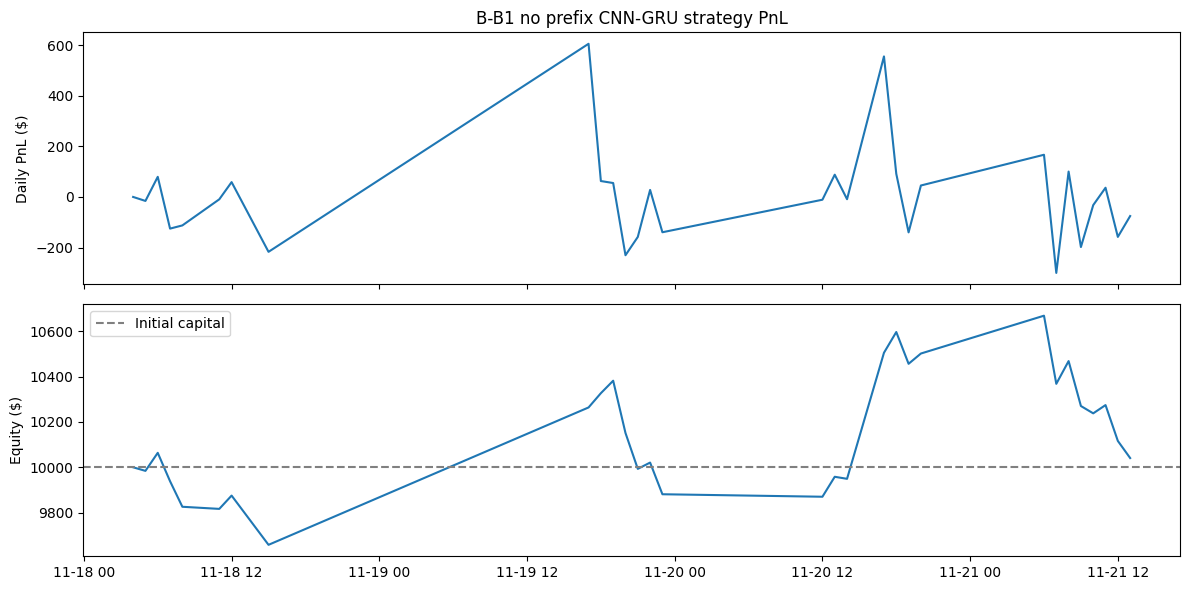

Final equity (B-B1 no prefix): $10040.78


In [23]:
# Simple long/short backtest driven by predicted labels (B-B1 no prefix)
signal_lookup = np.array([1, -1, 1, -1], dtype=np.int8)
val_signals = signal_lookup[val_pred]

def backtest(signals, prices, initial_capital=10000):
    capital = initial_capital
    equity = [capital]
    pnl = [0.0]
    for i in range(len(prices) - 1):
        today_price = prices[i]
        next_price = prices[i + 1]
        signal = signals[i]
        position_size = capital / today_price
        daily_pnl = position_size * (next_price - today_price) * signal
        capital += daily_pnl
        pnl.append(daily_pnl)
        equity.append(capital)
    return np.array(pnl), np.array(equity)

val_prices = pred_df["close"].values
pnl_curve, equity_curve = backtest(val_signals, val_prices)
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
axes[0].plot(pred_df.index, pnl_curve)
axes[0].set_ylabel("Daily PnL ($)")
axes[0].set_title("B-B1 no prefix CNN-GRU strategy PnL")
axes[1].plot(pred_df.index, equity_curve)
axes[1].axhline(10000, color="gray", linestyle="--", label="Initial capital")
axes[1].set_ylabel("Equity ($)")
axes[1].legend()
plt.tight_layout()
plt.show()
print(f"Final equity (B-B1 no prefix): ${equity_curve[-1]:.2f}")

equity_curves["B-B1 no prefix"] = pd.Series(equity_curve, index=pred_df.index, name="B-B1 no prefix")


# Model using B-B1 Aggregation

In [24]:
# Copies of train/validation tensors restricted to log price + B-B1 sentiment columns
bb1_cols = [col for col in feature_columns if col.lower().startswith("b_b1_prefix")]
if not bb1_cols:
    raise ValueError("No B-B1 columns found among sentiment features.")
bb1_feature_cols = derived_cols + bb1_cols
bb1_indices = [feature_columns.index(col) for col in bb1_feature_cols]
X_train_bb1 = X_train[..., bb1_indices].copy()
X_val_bb1 = X_val[..., bb1_indices].copy()
X_train_bb1.shape, X_val_bb1.shape

((116, 24, 6), (30, 24, 6))

In [25]:
# Sentiment-aware CNN-GRU architecture (log price + B-B1 features)
tf.keras.backend.clear_session()
model = models.Sequential([
    layers.Conv1D(64, kernel_size=3, activation="relu", padding="causal", input_shape=X_train_bb1.shape[1:]),
    layers.Conv1D(64, kernel_size=3, activation="relu", padding="causal"),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(64, kernel_size=3, activation="relu", padding="causal"),
    layers.Dropout(0.2),
    layers.GRU(64, return_sequences=False),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation="softmax"),
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

epochs = 40
batch_size = 32
history = model.fit(
    X_train_bb1,
    Y_train,
    validation_data=(X_val_bb1, Y_val),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
 )

c:\Users\User\Desktop\crowd_based_signals_for_crypto_trading\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 24, 64)         │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 24, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 12, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,300 (216.02 KB)

 Trainable params: 55,300 (216.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 261ms/step - accuracy: 0.4569 - loss: 1.3531 - val_accuracy: 0.4333 - val_loss: 1.3032
Epoch 2/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5776 - loss: 1.2007 - val_accuracy: 0.4333 - val_loss: 1.2868
Epoch 3/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5862 - loss: 1.1472 - val_accuracy: 0.4333 - val_loss: 1.3934
Epoch 4/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.5862 - loss: 1.1826 - val_accuracy: 0.4333 - val_loss: 1.3331
Epoch 5/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5862 - loss: 1.1687 - val_accuracy: 0.4333 - val_loss: 1.3110
Epoch 6/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5862 - loss: 1.1546 - val_accuracy: 0.4333 - val_loss: 1.3163
Epoch 7/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5862 - loss: 1.1668 - val_accuracy: 0.4333 - val_loss: 1.3395
Epoch 8/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5862 - loss: 1.1535 - val_accuracy: 0.4333 - val_loss: 1.3702

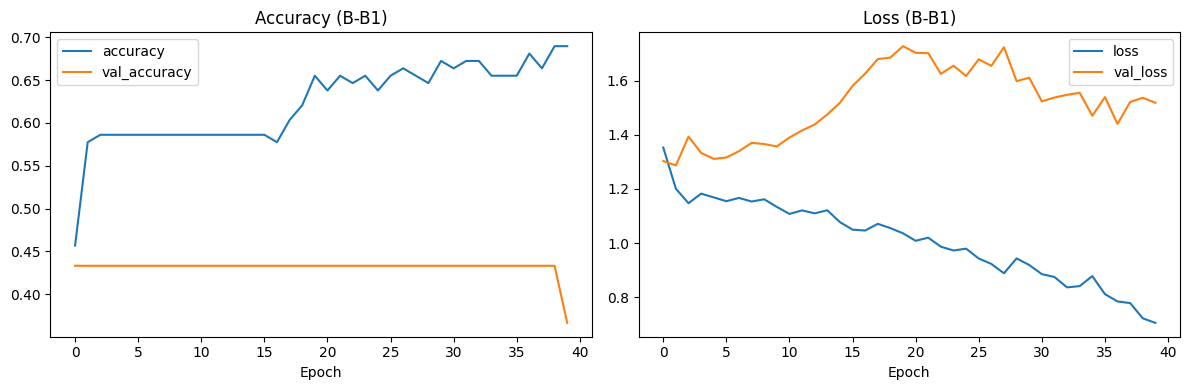

In [26]:
# Learning curves (B-B1)
history_df = pd.DataFrame(history.history)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
history_df[["accuracy", "val_accuracy"]].plot(ax=axes[0])
axes[0].set_title("Accuracy (B-B1)")
axes[0].set_xlabel("Epoch")
history_df[["loss", "val_loss"]].plot(ax=axes[1])
axes[1].set_title("Loss (B-B1)")
axes[1].set_xlabel("Epoch")
plt.tight_layout()

In [27]:
# Validation predictions and metrics
val_prob = model.predict(X_val_bb1)
val_pred = np.argmax(val_prob, axis=1)
val_true = np.argmax(Y_val, axis=1)
print("B-B1 Aggregation")
print(classification_report(val_true, val_pred, digits=3))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step
B-B1 Aggregation
              precision    recall  f1-score   support

           0      0.000     0.000     0.000         6
           1      0.000     0.000     0.000         2
           2      0.000     0.000     0.000         9
           3      0.393     0.846     0.537        13

    accuracy                          0.367        30
   macro avg      0.098     0.212     0.134        30
weighted avg      0.170     0.367     0.233        30



c:\Users\User\Desktop\crowd_based_signals_for_crypto_trading\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\User\Desktop\crowd_based_signals_for_crypto_trading\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\User\Desktop\crowd_based_signals_for_crypto_trading\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to co

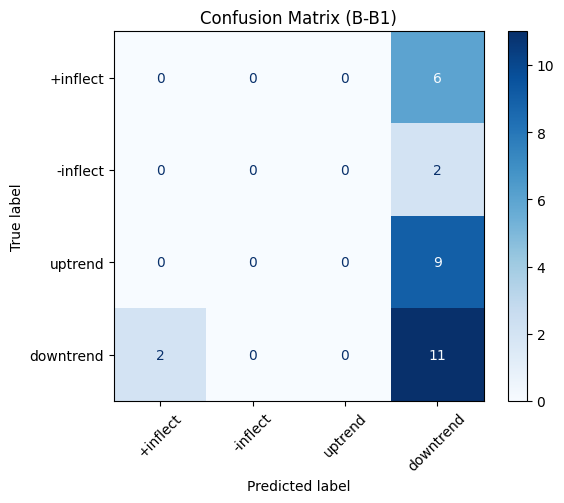

In [28]:
# Confusion matrix (B-B1)
cm = confusion_matrix(val_true, val_pred, labels=[0, 1, 2, 3])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["+inflect","-inflect","uptrend","downtrend"])
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix (B-B1)")
plt.show()

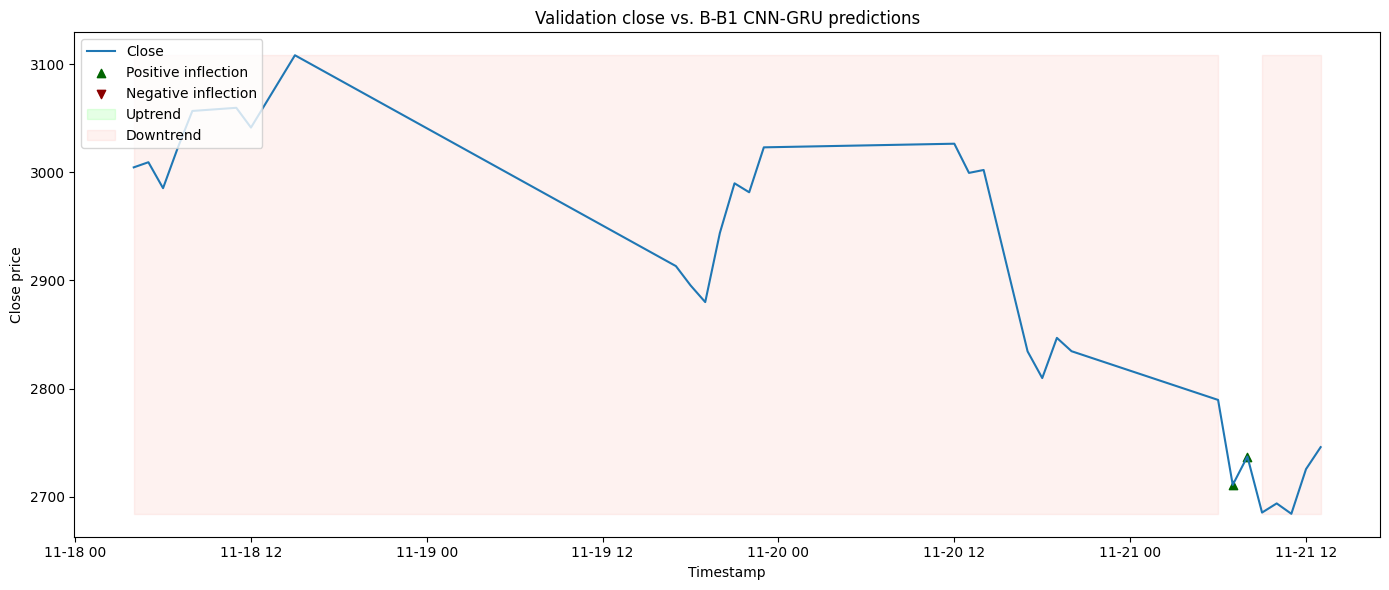

In [29]:
# Overlay predictions on price path (B-B1)
val_price_series = eth_hourly.loc[val_ts, "Close"]
pred_df = pd.DataFrame({
    "timestamp": val_ts,
    "close": val_price_series.values,
    "pred_label": val_pred,
}).set_index("timestamp")
plt.figure(figsize=(14, 6))
plt.plot(pred_df.index, pred_df["close"], label="Close")
mask_up = pred_df["pred_label"] == 2
mask_down = pred_df["pred_label"] == 3
mask_up_inflect = pred_df["pred_label"] == 0
mask_down_inflect = pred_df["pred_label"] == 1
plt.scatter(pred_df.index[mask_up_inflect], pred_df["close"][mask_up_inflect], marker="^", color="darkgreen", label="Positive inflection")
plt.scatter(pred_df.index[mask_down_inflect], pred_df["close"][mask_down_inflect], marker="v", color="darkred", label="Negative inflection")
plt.fill_between(pred_df.index, pred_df["close"].min(), pred_df["close"].max(), where=mask_up, alpha=0.1, color="lime", label="Uptrend")
plt.fill_between(pred_df.index, pred_df["close"].min(), pred_df["close"].max(), where=mask_down, alpha=0.1, color="salmon", label="Downtrend")
plt.title("Validation close vs. B-B1 CNN-GRU predictions")
plt.xlabel("Timestamp")
plt.ylabel("Close price")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

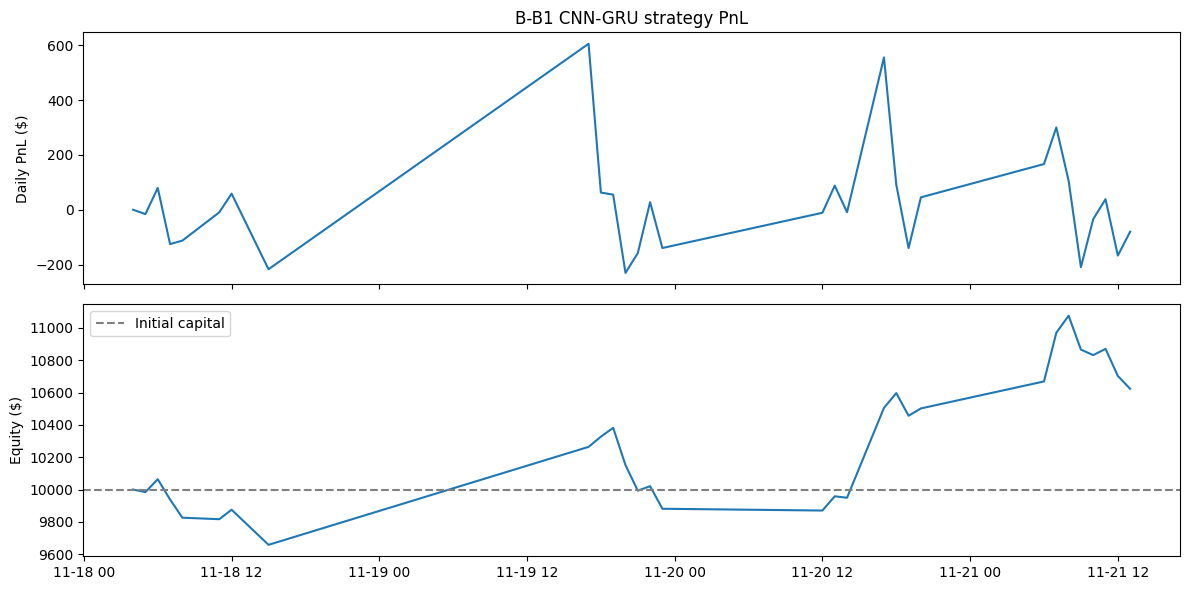

Final equity (B-B1): $10622.86


In [30]:
# Simple long/short backtest driven by predicted labels (B-B1)
signal_lookup = np.array([1, -1, 1, -1], dtype=np.int8)
val_signals = signal_lookup[val_pred]

def backtest(signals, prices, initial_capital=10000):
    capital = initial_capital
    equity = [capital]
    pnl = [0.0]
    for i in range(len(prices) - 1):
        today_price = prices[i]
        next_price = prices[i + 1]
        signal = signals[i]
        position_size = capital / today_price
        daily_pnl = position_size * (next_price - today_price) * signal
        capital += daily_pnl
        pnl.append(daily_pnl)
        equity.append(capital)
    return np.array(pnl), np.array(equity)

val_prices = pred_df["close"].values
pnl_curve, equity_curve = backtest(val_signals, val_prices)
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
axes[0].plot(pred_df.index, pnl_curve)
axes[0].set_ylabel("Daily PnL ($)")
axes[0].set_title("B-B1 CNN-GRU strategy PnL")
axes[1].plot(pred_df.index, equity_curve)
axes[1].axhline(10000, color="gray", linestyle="--", label="Initial capital")
axes[1].set_ylabel("Equity ($)")
axes[1].legend()
plt.tight_layout()
plt.show()
print(f"Final equity (B-B1): ${equity_curve[-1]:.2f}")

equity_curves["B-B1 prefix"] = pd.Series(equity_curve, index=pred_df.index, name="B-B1 prefix")


# Model using B-B2 Aggegation

In [31]:
# Copies of tensors restricted to log price + B-B2 sentiment columns
bb2_cols = [col for col in feature_columns if col.lower().startswith("b_b2_prefix")]
if not bb2_cols:
    raise ValueError("No B-B2 columns found among sentiment features.")
bb2_feature_cols = derived_cols + bb2_cols
bb2_indices = [feature_columns.index(col) for col in bb2_feature_cols]
X_train_bb2 = X_train[..., bb2_indices].copy()
X_val_bb2 = X_val[..., bb2_indices].copy()
X_train_bb2.shape, X_val_bb2.shape

((116, 24, 6), (30, 24, 6))

In [32]:
# Sentiment-aware CNN-GRU architecture (log price + B-B2 features)
tf.keras.backend.clear_session()
model_bb2 = models.Sequential([
    layers.Conv1D(64, kernel_size=3, activation="relu", padding="causal", input_shape=X_train_bb2.shape[1:]),
    layers.Conv1D(64, kernel_size=3, activation="relu", padding="causal"),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(64, kernel_size=3, activation="relu", padding="causal"),
    layers.Dropout(0.2),
    layers.GRU(64, return_sequences=False),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation="softmax"),
])
model_bb2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss="categorical_crossentropy", metrics=["accuracy"])
model_bb2.summary()

epochs_bb2 = 40
batch_size_bb2 = 32
history_bb2 = model_bb2.fit(
    X_train_bb2,
    Y_train,
    validation_data=(X_val_bb2, Y_val),
    epochs=epochs_bb2,
    batch_size=batch_size_bb2,
    verbose=1,
 )

c:\Users\User\Desktop\crowd_based_signals_for_crypto_trading\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 24, 64)         │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 24, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 12, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,300 (216.02 KB)

 Trainable params: 55,300 (216.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 258ms/step - accuracy: 0.5776 - loss: 1.2836 - val_accuracy: 0.4333 - val_loss: 1.2762
Epoch 2/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5862 - loss: 1.1612 - val_accuracy: 0.4333 - val_loss: 1.4345
Epoch 3/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5862 - loss: 1.1751 - val_accuracy: 0.4333 - val_loss: 1.3747
Epoch 4/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5862 - loss: 1.1877 - val_accuracy: 0.4333 - val_loss: 1.3106
Epoch 5/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5862 - loss: 1.1582 - val_accuracy: 0.4333 - val_loss: 1.3101
Epoch 6/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5862 - loss: 1.1564 - val_accuracy: 0.4333 - val_loss: 1.3307
Epoch 7/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5862 - loss: 1.1373 - val_accuracy: 0.4333 - val_loss: 1.3801
Epoch 8/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5862 - loss: 1.1235 - val_accuracy: 0.4333 - val_loss: 1.3802

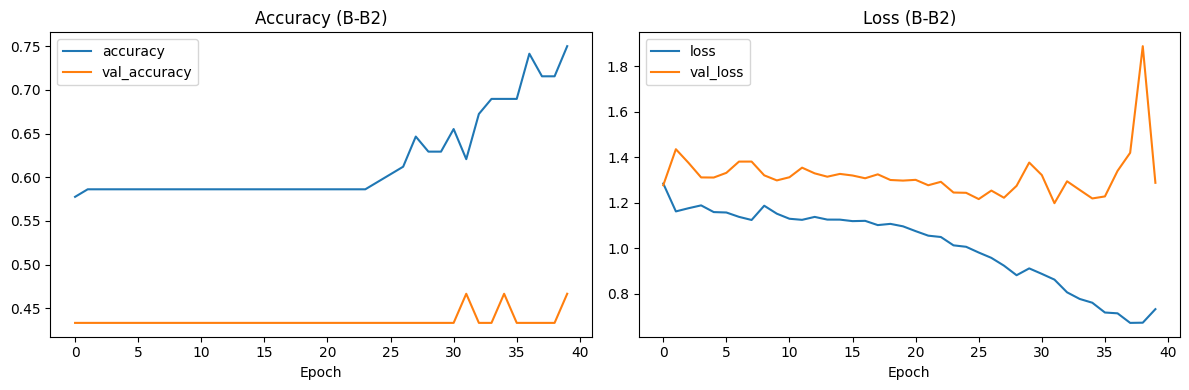

In [33]:
# Learning curves (B-B2)
history_bb2_df = pd.DataFrame(history_bb2.history)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
history_bb2_df[["accuracy", "val_accuracy"]].plot(ax=axes[0])
axes[0].set_title("Accuracy (B-B2)")
axes[0].set_xlabel("Epoch")
history_bb2_df[["loss", "val_loss"]].plot(ax=axes[1])
axes[1].set_title("Loss (B-B2)")
axes[1].set_xlabel("Epoch")
plt.tight_layout()

In [34]:
# Validation predictions and metrics (B-B2)
val_prob_bb2 = model_bb2.predict(X_val_bb2)
val_pred_bb2 = np.argmax(val_prob_bb2, axis=1)
val_true_bb2 = np.argmax(Y_val, axis=1)
print("B-B2 Aggregation")
print(classification_report(val_true_bb2, val_pred_bb2, digits=3))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
B-B2 Aggregation
              precision    recall  f1-score   support

           0      0.500     0.500     0.500         6
           1      0.000     0.000     0.000         2
           2      0.333     0.111     0.167         9
           3      0.476     0.769     0.588        13

    accuracy                          0.467        30
   macro avg      0.327     0.345     0.314        30
weighted avg      0.406     0.467     0.405        30



c:\Users\User\Desktop\crowd_based_signals_for_crypto_trading\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\User\Desktop\crowd_based_signals_for_crypto_trading\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\User\Desktop\crowd_based_signals_for_crypto_trading\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to co

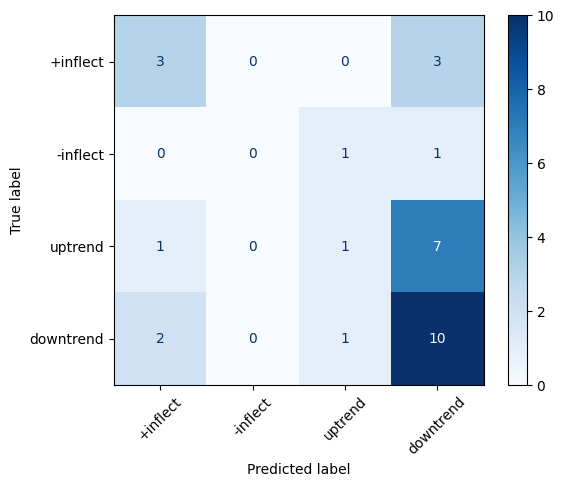

In [35]:
# Confusion matrix (B-B2)
cm_bb2 = confusion_matrix(val_true_bb2, val_pred_bb2, labels=[0, 1, 2, 3])
disp_bb2 = ConfusionMatrixDisplay(confusion_matrix=cm_bb2, display_labels=["+inflect","-inflect","uptrend","downtrend"])
disp_bb2.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.show()

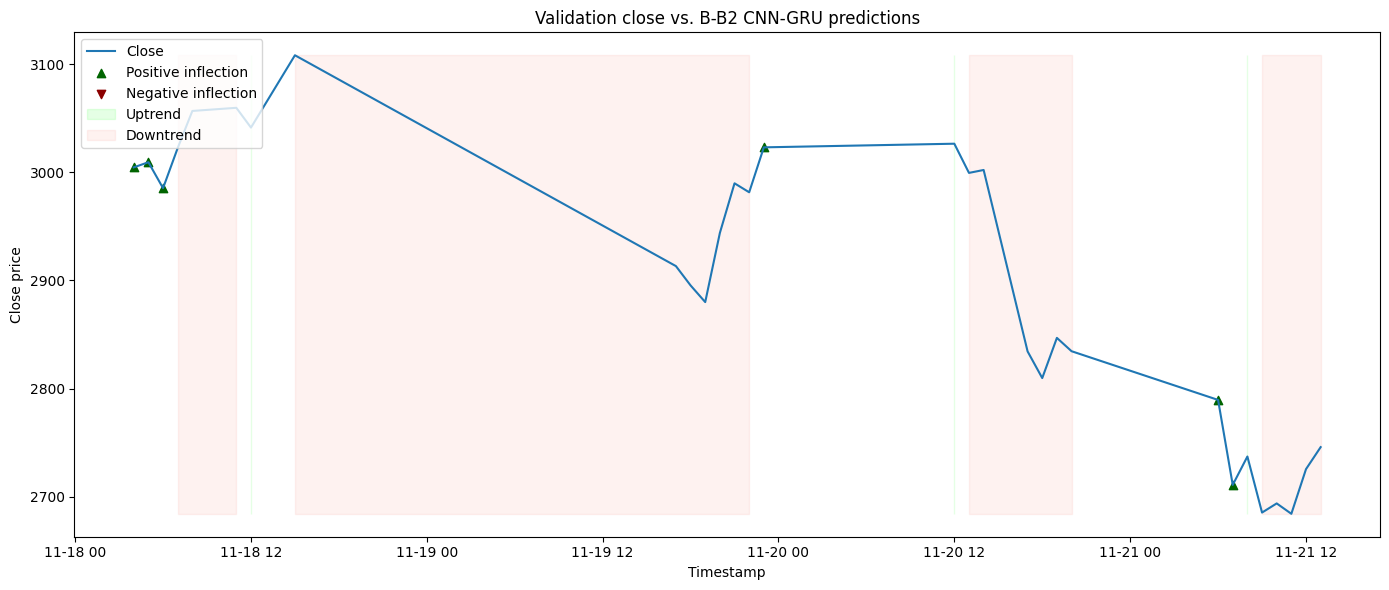

In [36]:
# Overlay predictions on price path (B-B2)
val_price_series_bb2 = eth_hourly.loc[val_ts, "Close"]
pred_df_bb2 = pd.DataFrame({
    "timestamp": val_ts,
    "close": val_price_series_bb2.values,
    "pred_label": val_pred_bb2,
}).set_index("timestamp")
plt.figure(figsize=(14, 6))
plt.plot(pred_df_bb2.index, pred_df_bb2["close"], label="Close")
mask_up_bb2 = pred_df_bb2["pred_label"] == 2
mask_down_bb2 = pred_df_bb2["pred_label"] == 3
mask_up_inflect_bb2 = pred_df_bb2["pred_label"] == 0
mask_down_inflect_bb2 = pred_df_bb2["pred_label"] == 1
plt.scatter(pred_df_bb2.index[mask_up_inflect_bb2], pred_df_bb2["close"][mask_up_inflect_bb2], marker="^", color="darkgreen", label="Positive inflection")
plt.scatter(pred_df_bb2.index[mask_down_inflect_bb2], pred_df_bb2["close"][mask_down_inflect_bb2], marker="v", color="darkred", label="Negative inflection")
plt.fill_between(pred_df_bb2.index, pred_df_bb2["close"].min(), pred_df_bb2["close"].max(), where=mask_up_bb2, alpha=0.1, color="lime", label="Uptrend")
plt.fill_between(pred_df_bb2.index, pred_df_bb2["close"].min(), pred_df_bb2["close"].max(), where=mask_down_bb2, alpha=0.1, color="salmon", label="Downtrend")
plt.title("Validation close vs. B-B2 CNN-GRU predictions")
plt.xlabel("Timestamp")
plt.ylabel("Close price")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

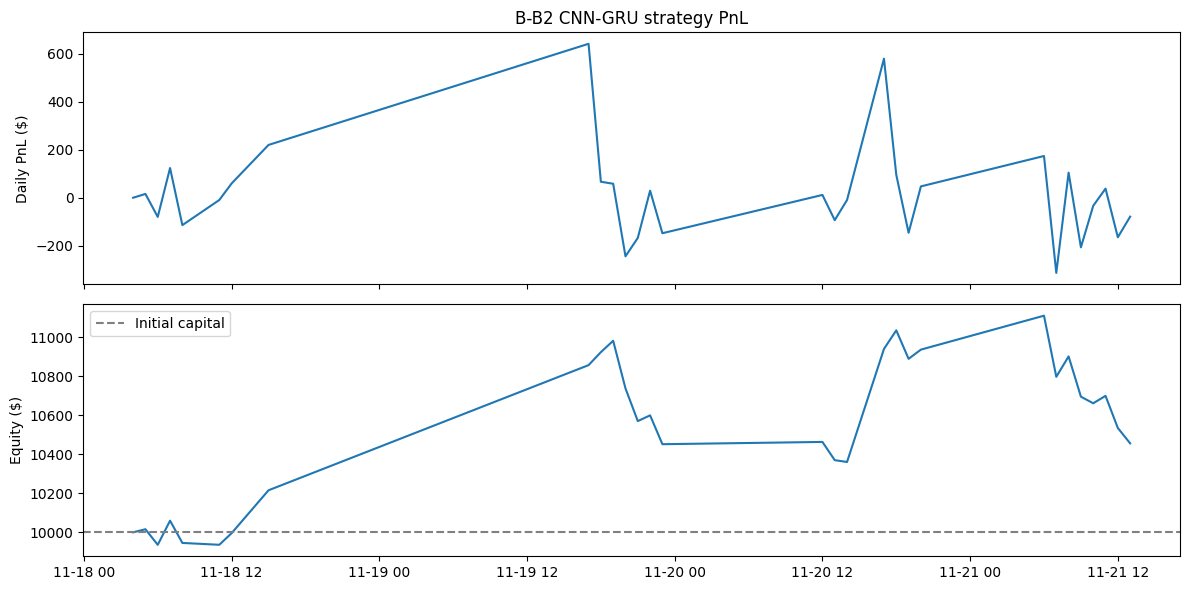

Final equity (B-B2): $10455.51


In [37]:
# Simple long/short backtest (B-B2)
val_signals_bb2 = signal_lookup[val_pred_bb2]
val_prices_bb2 = pred_df_bb2["close"].values
pnl_bb2, equity_bb2 = backtest(val_signals_bb2, val_prices_bb2)
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
axes[0].plot(pred_df_bb2.index, pnl_bb2)
axes[0].set_ylabel("Daily PnL ($)")
axes[0].set_title("B-B2 CNN-GRU strategy PnL")
axes[1].plot(pred_df_bb2.index, equity_bb2)
axes[1].axhline(10000, color="gray", linestyle="--", label="Initial capital")
axes[1].set_ylabel("Equity ($)")
axes[1].legend()
plt.tight_layout()
plt.show()
print(f"Final equity (B-B2): ${equity_bb2[-1]:.2f}")

equity_curves["B-B2 prefix"] = pd.Series(equity_bb2, index=pred_df_bb2.index, name="B-B2 prefix")


# Model using B-A4 Aggegation

In [38]:
# Copies of tensors restricted to log price + B-A4 sentiment columns
ba4_cols = [col for col in feature_columns if col.lower().startswith("b_a4_prefix")]
if not ba4_cols:
    raise ValueError("No B-A4 columns found among sentiment features.")
ba4_feature_cols = derived_cols + ba4_cols
ba4_indices = [feature_columns.index(col) for col in ba4_feature_cols]
X_train_ba4 = X_train[..., ba4_indices].copy()
X_val_ba4 = X_val[..., ba4_indices].copy()
X_train_ba4.shape, X_val_ba4.shape

((116, 24, 6), (30, 24, 6))

In [39]:
# Sentiment-aware CNN-GRU architecture (log price + B-A4 features)
tf.keras.backend.clear_session()
model_ba4 = models.Sequential([
    layers.Conv1D(64, kernel_size=3, activation="relu", padding="causal", input_shape=X_train_ba4.shape[1:]),
    layers.Conv1D(64, kernel_size=3, activation="relu", padding="causal"),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(64, kernel_size=3, activation="relu", padding="causal"),
    layers.Dropout(0.2),
    layers.GRU(64, return_sequences=False),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation="softmax"),
])
model_ba4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss="categorical_crossentropy", metrics=["accuracy"])
model_ba4.summary()

epochs_ba4 = 40
batch_size_ba4 = 32
history_ba4 = model_ba4.fit(
    X_train_ba4,
    Y_train,
    validation_data=(X_val_ba4, Y_val),
    epochs=epochs_ba4,
    batch_size=batch_size_ba4,
    verbose=1,
 )

c:\Users\User\Desktop\crowd_based_signals_for_crypto_trading\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 24, 64)         │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 24, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 12, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,300 (216.02 KB)

 Trainable params: 55,300 (216.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 260ms/step - accuracy: 0.5086 - loss: 1.3131 - val_accuracy: 0.4333 - val_loss: 1.2858
Epoch 2/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.5862 - loss: 1.1574 - val_accuracy: 0.4333 - val_loss: 1.3535
Epoch 3/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5862 - loss: 1.2131 - val_accuracy: 0.4333 - val_loss: 1.3591
Epoch 4/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5862 - loss: 1.1603 - val_accuracy: 0.4333 - val_loss: 1.3080
Epoch 5/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.5862 - loss: 1.1584 - val_accuracy: 0.4333 - val_loss: 1.3062
Epoch 6/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5862 - loss: 1.1414 - val_accuracy: 0.4333 - val_loss: 1.3264
Epoch 7/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5862 - loss: 1.1447 - val_accuracy: 0.4333 - val_loss: 1.3696
Epoch 8/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5862 - loss: 1.1331 - val_accuracy: 0.4333 - val_loss: 1.3736

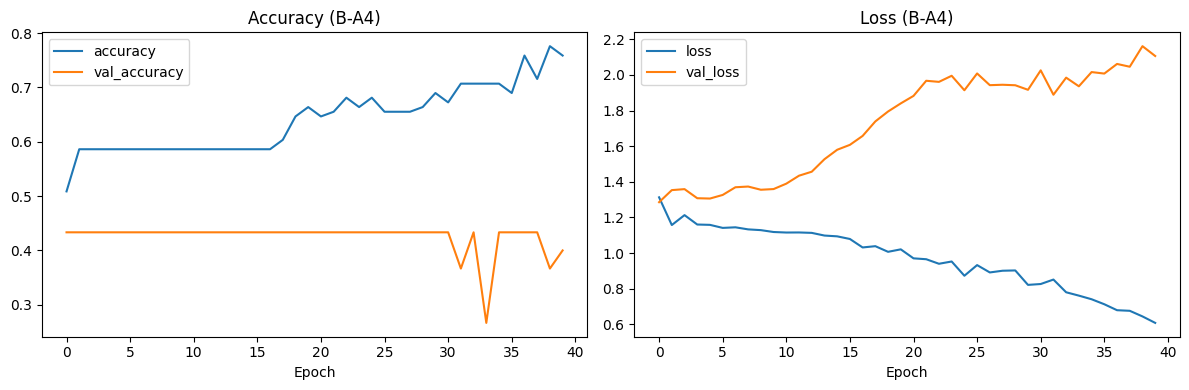

In [40]:
# Learning curves (B-A4)
history_ba4_df = pd.DataFrame(history_ba4.history)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
history_ba4_df[["accuracy", "val_accuracy"]].plot(ax=axes[0])
axes[0].set_title("Accuracy (B-A4)")
axes[0].set_xlabel("Epoch")
history_ba4_df[["loss", "val_loss"]].plot(ax=axes[1])
axes[1].set_title("Loss (B-A4)")
axes[1].set_xlabel("Epoch")
plt.tight_layout()

In [41]:
# Validation predictions and metrics (B-A4)
val_prob_ba4 = model_ba4.predict(X_val_ba4)
val_pred_ba4 = np.argmax(val_prob_ba4, axis=1)
val_true_ba4 = np.argmax(Y_val, axis=1)
print("B-A4 Aggregation")
print(classification_report(val_true_ba4, val_pred_ba4, digits=3))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
B-A4 Aggregation
              precision    recall  f1-score   support

           0      0.000     0.000     0.000         6
           1      0.000     0.000     0.000         2
           2      0.000     0.000     0.000         9
           3      0.414     0.923     0.571        13

    accuracy                          0.400        30
   macro avg      0.103     0.231     0.143        30
weighted avg      0.179     0.400     0.248        30



c:\Users\User\Desktop\crowd_based_signals_for_crypto_trading\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\User\Desktop\crowd_based_signals_for_crypto_trading\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\User\Desktop\crowd_based_signals_for_crypto_trading\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to co

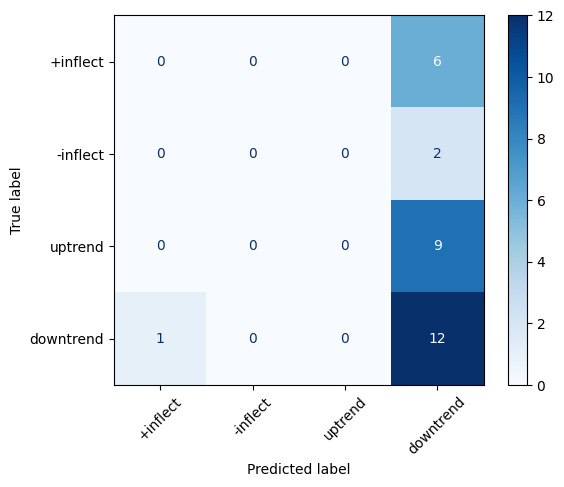

In [42]:
# Confusion matrix (B-A4)
cm_ba4 = confusion_matrix(val_true_ba4, val_pred_ba4, labels=[0, 1, 2, 3])
disp_ba4 = ConfusionMatrixDisplay(confusion_matrix=cm_ba4, display_labels=["+inflect","-inflect","uptrend","downtrend"])
disp_ba4.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.show()

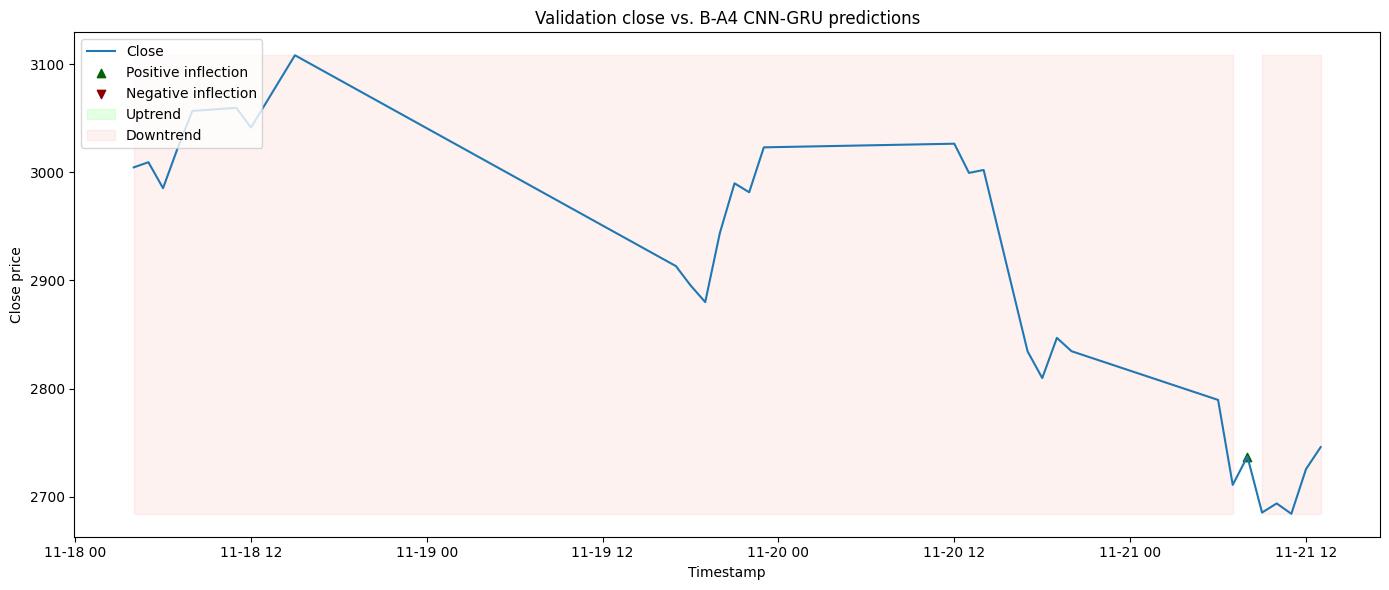

In [43]:
# Overlay predictions on price path (B-A4)
val_price_series_ba4 = eth_hourly.loc[val_ts, "Close"]
pred_df_ba4 = pd.DataFrame({
    "timestamp": val_ts,
    "close": val_price_series_ba4.values,
    "pred_label": val_pred_ba4,
}).set_index("timestamp")
plt.figure(figsize=(14, 6))
plt.plot(pred_df_ba4.index, pred_df_ba4["close"], label="Close")
mask_up_ba4 = pred_df_ba4["pred_label"] == 2
mask_down_ba4 = pred_df_ba4["pred_label"] == 3
mask_up_inflect_ba4 = pred_df_ba4["pred_label"] == 0
mask_down_inflect_ba4 = pred_df_ba4["pred_label"] == 1
plt.scatter(pred_df_ba4.index[mask_up_inflect_ba4], pred_df_ba4["close"][mask_up_inflect_ba4], marker="^", color="darkgreen", label="Positive inflection")
plt.scatter(pred_df_ba4.index[mask_down_inflect_ba4], pred_df_ba4["close"][mask_down_inflect_ba4], marker="v", color="darkred", label="Negative inflection")
plt.fill_between(pred_df_ba4.index, pred_df_ba4["close"].min(), pred_df_ba4["close"].max(), where=mask_up_ba4, alpha=0.1, color="lime", label="Uptrend")
plt.fill_between(pred_df_ba4.index, pred_df_ba4["close"].min(), pred_df_ba4["close"].max(), where=mask_down_ba4, alpha=0.1, color="salmon", label="Downtrend")
plt.title("Validation close vs. B-A4 CNN-GRU predictions")
plt.xlabel("Timestamp")
plt.ylabel("Close price")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

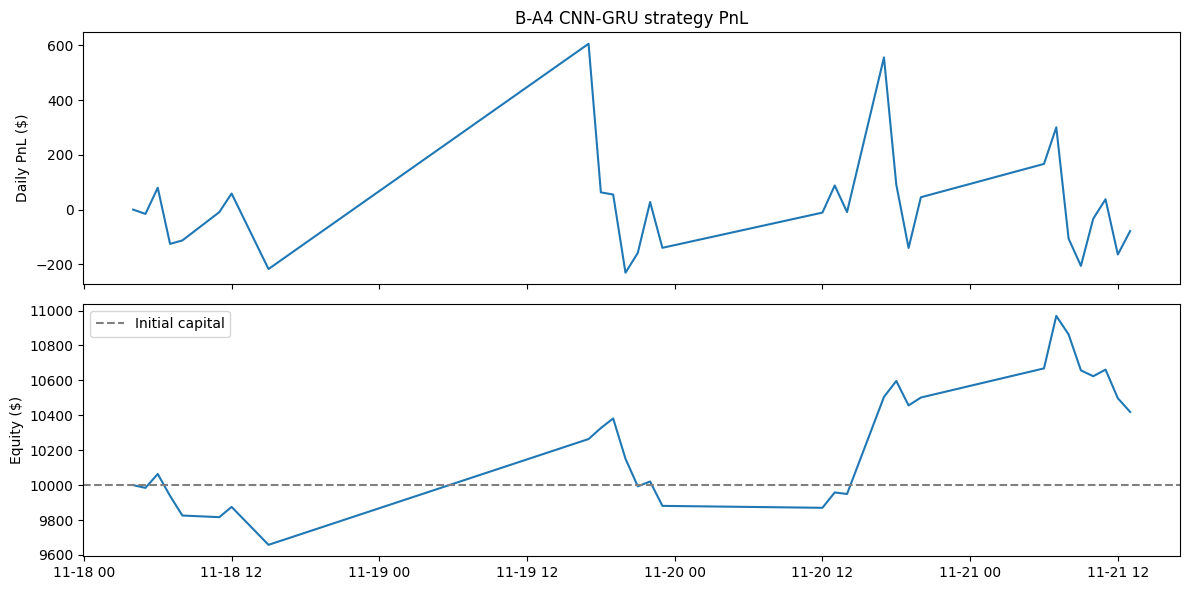

Final equity (B-A4): $10419.19


In [44]:
# Simple long/short backtest (B-A4)
val_signals_ba4 = signal_lookup[val_pred_ba4]
val_prices_ba4 = pred_df_ba4["close"].values
pnl_ba4, equity_ba4 = backtest(val_signals_ba4, val_prices_ba4)
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
axes[0].plot(pred_df_ba4.index, pnl_ba4)
axes[0].set_ylabel("Daily PnL ($)")
axes[0].set_title("B-A4 CNN-GRU strategy PnL")
axes[1].plot(pred_df_ba4.index, equity_ba4)
axes[1].axhline(10000, color="gray", linestyle="--", label="Initial capital")
axes[1].set_ylabel("Equity ($)")
axes[1].legend()
plt.tight_layout()
plt.show()
print(f"Final equity (B-A4): ${equity_ba4[-1]:.2f}")

equity_curves["B-A4 prefix"] = pd.Series(equity_ba4, index=pred_df_ba4.index, name="B-A4 prefix")


# Price Only Model

In [45]:
# Price-only feature matrix and sequences
price_only_frame = feature_frame[derived_cols].copy()
scaler_price_only = MinMaxScaler()
price_only_scaled = pd.DataFrame(
    scaler_price_only.fit_transform(price_only_frame),
    index=price_only_frame.index,
    columns=derived_cols,
 )
X_seq_price, y_seq_price, ts_price = create_sequences(price_only_scaled, labels_aligned, lookback)
y_seq_price_ohe = to_categorical(y_seq_price, num_classes=num_classes)
X_seq_price.shape, y_seq_price_ohe.shape

((146, 24, 5), (146, 4))

In [46]:
# Use identical chronological split
split_idx_price = int(0.8 * len(X_seq_price))
X_train_price, X_val_price = X_seq_price[:split_idx_price], X_seq_price[split_idx_price:]
Y_train_price, Y_val_price = y_seq_price_ohe[:split_idx_price], y_seq_price_ohe[split_idx_price:]
train_ts_price, val_ts_price = ts_price[:split_idx_price], ts_price[split_idx_price:]
assert np.array_equal(val_ts_price, val_ts[: len(val_ts_price)])
X_train_price.shape, X_val_price.shape

((116, 24, 5), (30, 24, 5))

In [47]:
# CNN-GRU architecture without sentiment inputs
tf.keras.backend.clear_session()
model_price = models.Sequential([
    layers.Conv1D(64, kernel_size=3, activation="relu", padding="causal", input_shape=X_train_price.shape[1:]),
    layers.Conv1D(64, kernel_size=3, activation="relu", padding="causal"),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(64, kernel_size=3, activation="relu", padding="causal"),
    layers.Dropout(0.2),
    layers.GRU(64, return_sequences=False),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation="softmax"),
])
model_price.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss="categorical_crossentropy", metrics=["accuracy"])
model_price.summary()

c:\Users\User\Desktop\crowd_based_signals_for_crypto_trading\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 24, 64)         │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 24, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 12, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,108 (215.27 KB)

 Trainable params: 55,108 (215.27 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
# Train price-only model
history_price = model_price.fit(
    X_train_price,
    Y_train_price,
    validation_data=(X_val_price, Y_val_price),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
)

Epoch 1/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 288ms/step - accuracy: 0.4224 - loss: 1.3649 - val_accuracy: 0.4333 - val_loss: 1.3172
Epoch 2/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.5862 - loss: 1.2441 - val_accuracy: 0.4333 - val_loss: 1.3189
Epoch 3/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.5862 - loss: 1.1644 - val_accuracy: 0.4333 - val_loss: 1.4674
Epoch 4/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.5862 - loss: 1.1591 - val_accuracy: 0.4333 - val_loss: 1.3749
Epoch 5/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5862 - loss: 1.1433 - val_accuracy: 0.4333 - val_loss: 1.3147
Epoch 6/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5862 - loss: 1.1676 - val_accuracy: 0.4333 - val_loss: 1.3150
Epoch 7/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5862 - loss: 1.1350 - val_accuracy: 0.4333 - val_loss: 1.3471
Epoch 8/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.5862 - loss: 1.1488 - val_accuracy: 0.4333 - val_loss: 1.3663

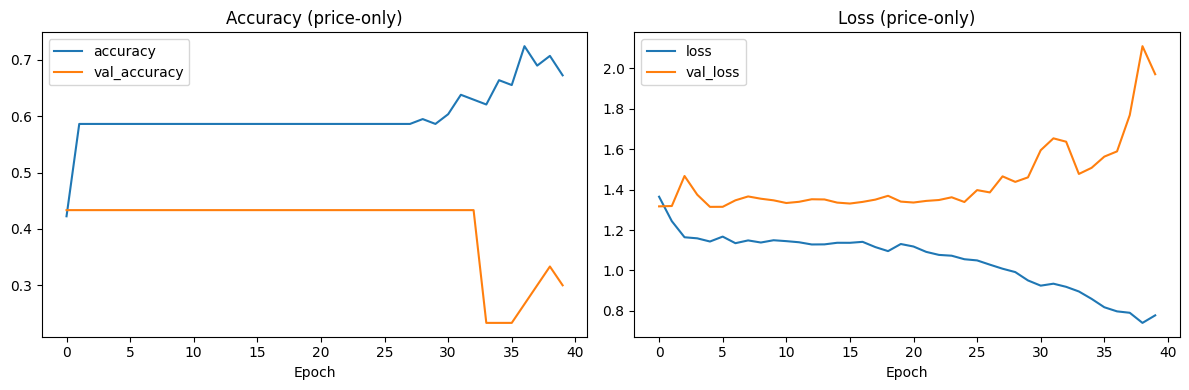

In [49]:
# Learning curves (price-only)
history_price_df = pd.DataFrame(history_price.history)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
history_price_df[["accuracy", "val_accuracy"]].plot(ax=axes[0])
axes[0].set_title("Accuracy (price-only)")
axes[0].set_xlabel("Epoch")
history_price_df[["loss", "val_loss"]].plot(ax=axes[1])
axes[1].set_title("Loss (price-only)")
axes[1].set_xlabel("Epoch")
plt.tight_layout()

In [50]:
# Validation metrics (price-only)
val_prob_price = model_price.predict(X_val_price)
val_pred_price = np.argmax(val_prob_price, axis=1)
val_true_price = np.argmax(Y_val_price, axis=1)
print(classification_report(val_true_price, val_pred_price, digits=3))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
              precision    recall  f1-score   support

           0      0.000     0.000     0.000         6
           1      0.000     0.000     0.000         2
           2      0.000     0.000     0.000         9
           3      0.346     0.692     0.462        13

    accuracy                          0.300        30
   macro avg      0.087     0.173     0.115        30
weighted avg      0.150     0.300     0.200        30



c:\Users\User\Desktop\crowd_based_signals_for_crypto_trading\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\User\Desktop\crowd_based_signals_for_crypto_trading\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\User\Desktop\crowd_based_signals_for_crypto_trading\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to co

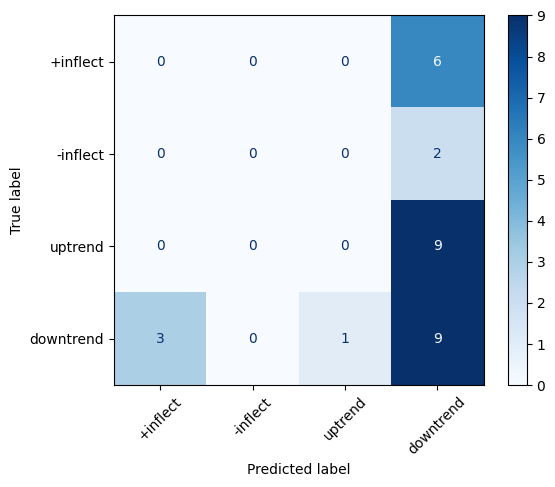

In [51]:
# Confusion matrix (price-only)
cm_price = confusion_matrix(val_true_price, val_pred_price, labels=[0, 1, 2, 3])
disp_price = ConfusionMatrixDisplay(confusion_matrix=cm_price, display_labels=["+inflect","-inflect","uptrend","downtrend"])
disp_price.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.show()

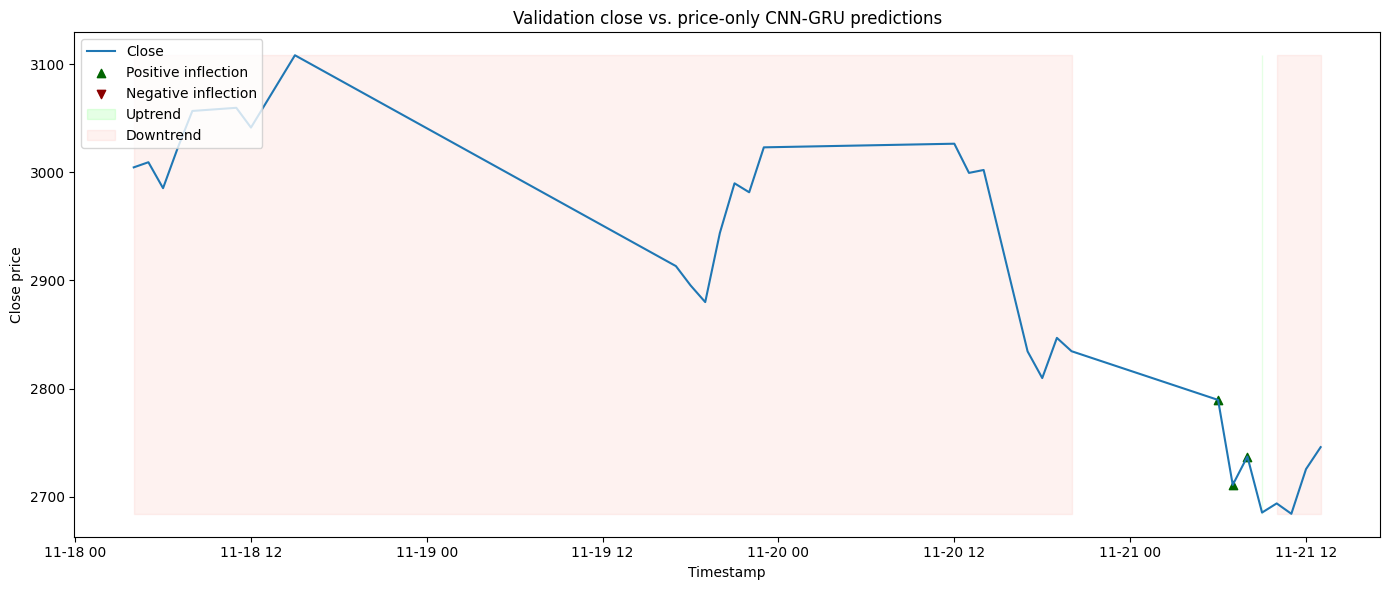

In [52]:
# Price-only prediction overlay
val_price_series_price = eth_hourly.loc[val_ts_price, "Close"]
pred_df_price = pd.DataFrame({
    "timestamp": val_ts_price,
    "close": val_price_series_price.values,
    "pred_label": val_pred_price,
}).set_index("timestamp")
plt.figure(figsize=(14, 6))
plt.plot(pred_df_price.index, pred_df_price["close"], label="Close")
mask_up_price = pred_df_price["pred_label"] == 2
mask_down_price = pred_df_price["pred_label"] == 3
mask_up_inflect_price = pred_df_price["pred_label"] == 0
mask_down_inflect_price = pred_df_price["pred_label"] == 1
plt.scatter(pred_df_price.index[mask_up_inflect_price], pred_df_price["close"][mask_up_inflect_price], marker="^", color="darkgreen", label="Positive inflection")
plt.scatter(pred_df_price.index[mask_down_inflect_price], pred_df_price["close"][mask_down_inflect_price], marker="v", color="darkred", label="Negative inflection")
plt.fill_between(pred_df_price.index, pred_df_price["close"].min(), pred_df_price["close"].max(), where=mask_up_price, alpha=0.1, color="lime", label="Uptrend")
plt.fill_between(pred_df_price.index, pred_df_price["close"].min(), pred_df_price["close"].max(), where=mask_down_price, alpha=0.1, color="salmon", label="Downtrend")
plt.title("Validation close vs. price-only CNN-GRU predictions")
plt.xlabel("Timestamp")
plt.ylabel("Close price")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

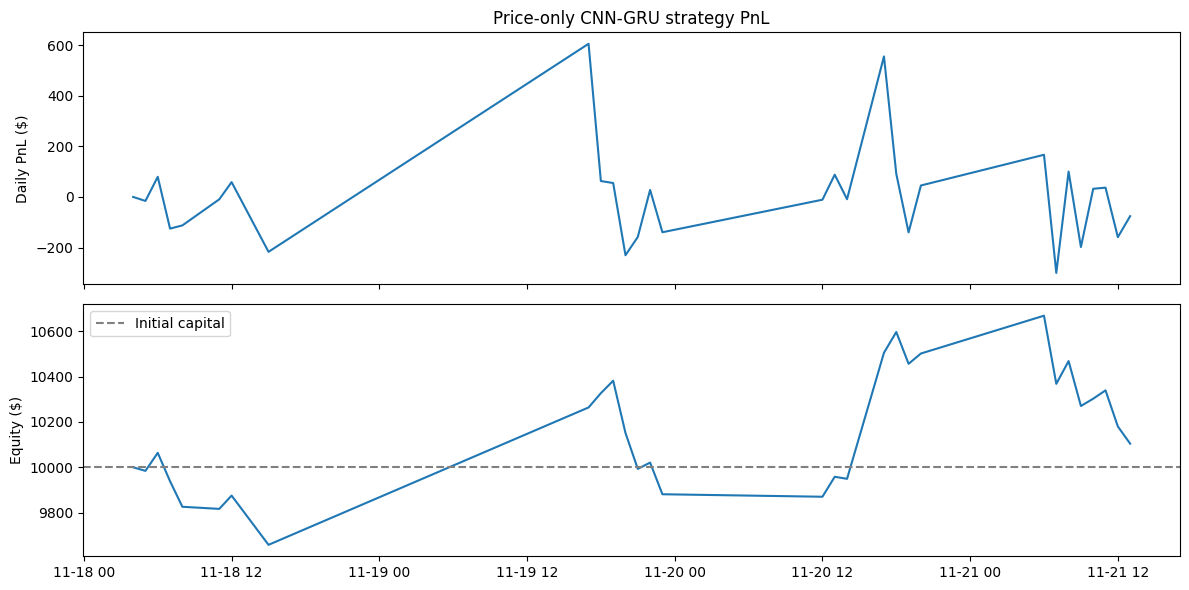

Final equity (price-only): $10104.19


In [53]:
# Price-only backtest
val_signals_price = signal_lookup[val_pred_price]
val_prices_price = pred_df_price["close"].values
pnl_price, equity_price = backtest(val_signals_price, val_prices_price)
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
axes[0].plot(pred_df_price.index, pnl_price)
axes[0].set_ylabel("Daily PnL ($)")
axes[0].set_title("Price-only CNN-GRU strategy PnL")
axes[1].plot(pred_df_price.index, equity_price)
axes[1].axhline(10000, color="gray", linestyle="--", label="Initial capital")
axes[1].set_ylabel("Equity ($)")
axes[1].legend()
plt.tight_layout()
plt.show()
print(f"Final equity (price-only): ${equity_price[-1]:.2f}")

equity_curves["Price-only"] = pd.Series(equity_price, index=pred_df_price.index, name="Price-only")


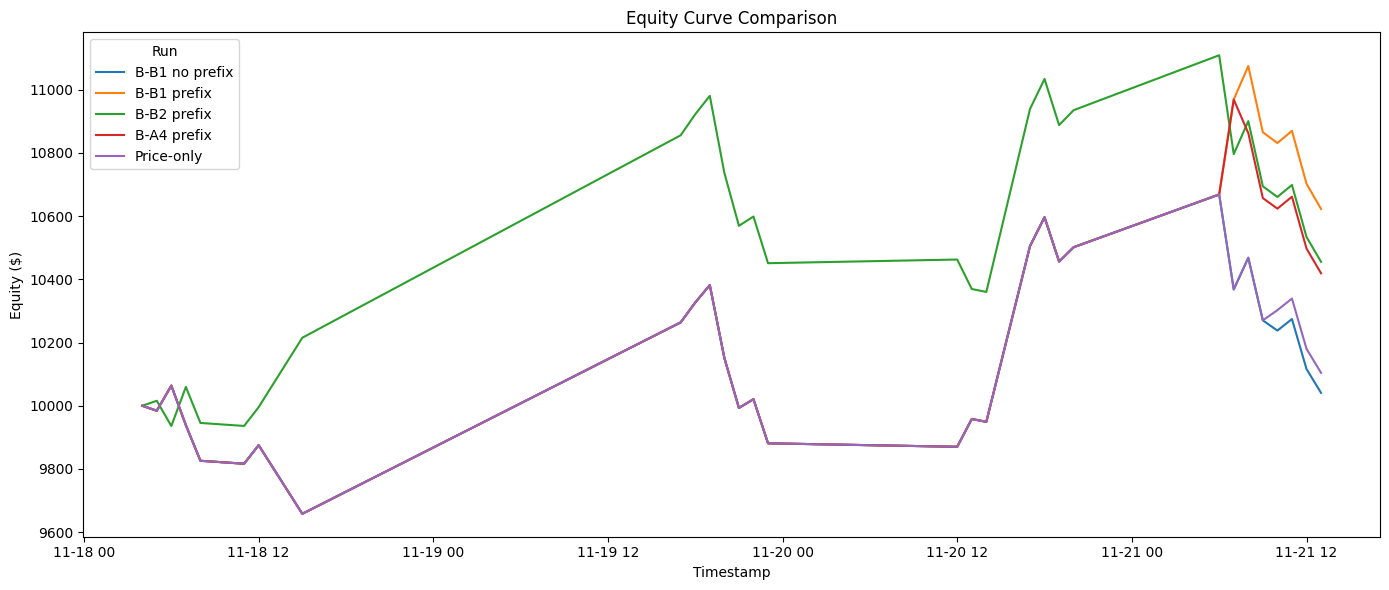

In [54]:
# Combined equity curve comparison across all experiment variants
if not equity_curves:
    raise ValueError("Run the individual experiment cells before generating the combined equity plot.")

aligned_equities = []
common_index = None
for name, series in equity_curves.items():
    ordered_series = series.sort_index()
    aligned_equities.append((name, ordered_series))
    common_index = ordered_series.index if common_index is None else common_index.intersection(ordered_series.index)

if common_index is None or len(common_index) == 0:
    raise ValueError("No overlapping timestamps were found across the stored equity curves.")

combined_equity = pd.concat(
    [series.reindex(common_index).rename(name) for name, series in aligned_equities],
    axis=1,
)

plt.figure(figsize=(14, 6))
for column in combined_equity.columns:
    plt.plot(combined_equity.index, combined_equity[column], label=column)
plt.title("Equity Curve Comparison")
plt.xlabel("Timestamp")
plt.ylabel("Equity ($)")
plt.legend(loc="upper left", title="Run")
plt.tight_layout()
plt.show()
